In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.font_manager
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
import folium
# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'NEXON' in f.name]
# print ('캐시 위치: ', matplotlib.get_cachedir())

plt.style.use('seaborn-dark')
plt.rcParams["font.family"] = 'NEXON Lv2 Gothic'
plt.rcParams["font.weight"] = 'light'

plt.rcParams['axes.unicode_minus'] = False

In [2]:
station = pd.read_csv(
    "assets/newStationInfo.csv", index_col=0,encoding='cp949'
)

near_bus = pd.read_csv(
    "assets/near_bus_500m.csv", encoding="CP949", index_col=0
)

seoul_bike = pd.read_parquet("/Users/yangwoolee/git_repo/seoulBikeProject/parquet/220607_bike_record.parquet.gzip")

sub_info = pd.read_csv(
    "assets/sub_and_bike_info.csv", encoding="CP949", index_col=0
)

search_info = pd.read_csv(
    "assets/search_info.csv", encoding="CP949", index_col=0
)
btstation = pd.read_csv(
    "assets/btbtstation_info.csv", encoding="CP949", index_col=0
)

near_sub = pd.read_csv(
    "assets/near_sub_station.csv", encoding="CP949", index_col=0
)

In [3]:
stid=station.sort_values(by='num',ascending=False)['st_id'][:300]

result = []
for i in stid :
    k = seoul_bike[seoul_bike['st_id1'] == i]
    kkk = k.groupby(by='st_id2').size()
    kkk80 = kkk[kkk >= kkk.quantile(0.80)]
    result.append([len(kkk80),len(kkk),np.sum(kkk80)/np.sum(kkk)])

k = pd.DataFrame(result)
k.columns = '20% 대여소',"전체 대여소",'대여 퍼센트'

k.mean()

20% 대여소    122.646667
전체 대여소     603.733333
대여 퍼센트       0.896507
dtype: float64

In [3]:
def haversine_np(
    lon1: float, lat1: float, lon2: float, lat2: float
) -> np.array:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

def raw_data( val: int) -> pd.DataFrame:
    quert_st_id1 = seoul_bike[seoul_bike["st_id1"] == val]
    quert_st_id2 = seoul_bike[seoul_bike["st_id2"] == val]
    filtered_data = pd.concat(
        [quert_st_id1, quert_st_id2], axis=0
    ).drop_duplicates()
    filtered_data.drop(columns="index", inplace=True)
    bm = (filtered_data["st_id1"] == val) & (filtered_data["st_id2"] == val)
    filtered_data = filtered_data[~bm]

    # # 반납
    # filtered_data_end = filtered_data[
    #     (filtered_data["st_id2"] == val) & (filtered_data["st_id1"] != val)
    # ]

    return filtered_data

# def findInteractionNum(id:int) :
def stationInteraction(id:int) :
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    data = stationInteraction[stationInteraction>=int(len(stationInteraction)/1000)].sort_values(ascending=False)
    result = pd.DataFrame(data).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2',0]]
    return result

### Filtering Station

In [4]:
# 1000m 내에 있는 대여소 제거
def filterIn1000M(id:int) -> pd.DataFrame :
    k = station[station['st_id'] == id]
    tLong = k['longtitude'].values
    tLat = k['latitude'].values
    bLong=station['longtitude']
    bLat=station['latitude']
    dist = haversine_np(tLong,tLat,bLong,bLat)

    subInfoCopy = station.copy()
    subInfoCopy['dist'] = dist
    bikeSort = subInfoCopy[(dist < 1000)]

    return bikeSort

# 대여기록 비율 1/2 차이나는 경우 station으로 미포함
def calculateBikeRate(id1:int, id2:int, rawData)-> pd.Series :
    k = rawData[(rawData['st_id1'] == id1) & (rawData['st_id2'] == id2)] # 주 목적
    kk = rawData[(rawData['st_id1'] == id2) & (rawData['st_id2'] == id1)] # 비교 목적
    if len(k) and len(kk) :
        rere = np.log2(len(k)/len(kk))
        if rere > -1 :
            return k    

# 조건 1,2 정제해서 index로 반환
def filterConditions(id1:int,rawData) -> np.array :
    # rawData = raw_data(id1)
    id2List = filterIn1000M(id1)['st_id'].to_numpy()

    # 조건 1 : 대여기록 0.001 이상
    id1Value = rawData['st_id2'].value_counts()[1:]
    id1List= id1Value[id1Value>int(len(rawData)*0.001)].index.to_numpy() 

    #조건 2 : 비율 2배 이상, 고도 차이 20m 이상 제거
    filteredidx = id1List[~(np.in1d(id1List,id2List))] 
    result = [calculateBikeRate(id1,id2,rawData) for id2 in filteredidx]

    returnValue : np.array = pd.concat(result)['st_id2'].value_counts().index.to_numpy()
    return returnValue

#예시
# len(filterConditions(758,rawData=raw_data(758)))
# filterIn1000M(758)
# arrStation(758)


In [5]:
# 예상거리, 시간, 출발 대여소까지 직선 거리 계산
def filterRawStations(st_id: int) -> pd.DataFrame:
    filtered_data = raw_data(st_id)

    # 대여소 idx 추출
    station_id = filterConditions(st_id,filtered_data).tolist()
    result = station[station['st_id'].isin(station_id)].reset_index(drop=True)

    result_station = []
    for j in result['st_id']:
        # 예상시간 계산
        BM = filtered_data["st_id2"] == j

        all_rent = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )

        ### 대여기록
        total_record = all_rent.sum()

        k = []
        i = 2
        ### 기록 많은 순만 종합
        while len(k) < 1:
            k = all_rent[all_rent >= (total_record / i)]
            i = i * 1.5

        ### 대여시간
        ind = k.index

        ### 대여기록
        val = k.values

        ### 대여기록 합
        a = k.sum()

        ### 대여시간 * 대여기록
        asddd = sum([a * b for a, b in zip(ind, val)])

        # 평균 시간
        ddddd = asddd / a

        # 올림
        val = round(ddddd, 0)

        ### 이동거리 계산
        BM = filtered_data["st_id2"] == j
        all_rent = (
            filtered_data[BM]["dist"].value_counts().sort_values(ascending=False)
        )

        dist = (
            pd.cut(all_rent.index, bins=50)
            .value_counts()
            .sort_values(ascending=False)
        )
        # 상위 3개 값을 평균냄. mid는 pd.interval 매서드에서 쓰는 변수임.
        num = 3
        vals = [dist[:num].index[a].mid * dist.iloc[a] for a in range(num)]
        avg_dist = sum(vals) / sum(dist.to_list()[:num])
        result_station.append([val, total_record, (round(avg_dist / 1000, 2))])
    
    # 결과 종합
    df = pd.DataFrame(result_station)

    # haversineDist 계산
    dep = station[station['st_id'].isin([st_id])]
    arr = result

    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']

    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(round(dist/1000,2),columns=['haversineDist'])

    # 데이터 종합
    data = pd.concat([result, df,dist], axis=1)
    data.columns = ['st_id','st_name','district','latitude', 'longtitude','num',  'elevation','ridingTime','record','ridingDist','haversineDist']
    data=data[data['st_id'] != st_id]

    return data

### 예시
filterRawStations(207)

,st_id,st_name,district,latitude,longtitude,num,elevation,ridingTime,record,ridingDist,haversineDist
0,106,합정역 7번출구 앞,마포구,37.548645,126.912827,63341.0,16.01,38.0,714,5.70,2.95
1,111,상수역 2번출구 앞,마포구,37.547871,126.923531,27009.0,22.17,37.0,199,4.76,2.44
2,114,홍대입구역 8번출구 앞,마포구,37.557060,126.924423,59233.0,12.07,46.0,191,6.63,3.41
3,119,서강나루 공원,마포구,37.545284,126.931053,27721.0,13.02,16.0,238,3.40,2.04
4,130,신촌역(2호선) 7번출구 앞,마포구,37.554859,126.936157,35571.0,19.44,38.0,194,5.09,3.12
...,...,...,...,...,...,...,...,...,...,...,...
77,3794,안양천합수부(현대3차아파트),강서구,37.552246,126.876488,27755.0,7.15,34.0,405,6.83,5.65
78,4559,신길역 2번출구,영등포구,37.517563,126.916985,17128.0,18.68,15.0,300,1.98,1.69
79,4568,영등포로터리,영등포구,37.518749,126.912209,13119.0,11.10,18.0,218,2.58,1.98
80,152,마포구민체육센터 앞,마포구,37.556610,126.898018,104386.0,9.01,44.0,261,7.22,4.46


In [6]:
# station.sort_values(by='num',ascending=False)[207:25]

# haversineDist 계산
def rawStation(id:int) :

    rawData = raw_data(id)
    id1Value = rawData['st_id2'].value_counts()[1:]
    id1List= id1Value[id1Value>int(len(rawData)*0.0005)].index.to_numpy() 

    dep = station[station['st_id'].isin([id])]
    arr = station[station['st_id'].isin(id1List)].reset_index(drop=True)

    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']

    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(round(dist/1000,2),columns=['haversineDist'])

    rawStation = pd.concat([arr,dist], axis=1)

    rawStation['distLabel']=rawStation['haversineDist'].astype(int)

    return rawStation


### 원본

In [7]:
id=207
sortedStation = rawStation(id)
sortedStation['districtLabel'] = sortedStation['haversineDist'].astype(int)
mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

# colors = ['red','orange','blue','green','purple','beige','brown','yellow','navy','gray','red','orange','blue','green','purple','beige','brown','yellow','navy','gray']
for i, c in enumerate(sortedStation['districtLabel'].tolist()) : 
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.5).add_to(geomap)
    # folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)]).add_to(geomap)
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color='green').add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)

geomap

### 초기 Img : 대여기록 0.005 미만 제거 


In [10]:
id=207
sortedStation= filterRawStations(id)
sortedStation['districtLabel'] = sortedStation['haversineDist'].astype(int)
mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

# colors = ['red','orange','blue','green','purple','beige','brown','yellow','navy','gray','red','orange','blue','green','purple','beige','brown','yellow','navy','gray']
for i, c in enumerate(sortedStation['districtLabel'].tolist()) : 
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.5).add_to(geomap)
    # folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)]).add_to(geomap)
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color='green').add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)

geomap

In [11]:

id = 207
sortedStation = rawStation(id).query('2<distLabel<=4')
kmeansExample = KMeans(n_clusters=5, random_state=42)
kmeansExample.fit(sortedStation[['latitude','longtitude']])
sortedStation['districtLabel'] = kmeansExample.labels_

mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

# colors = ['red','orange','blue','green','purple']
for i, c in enumerate(sortedStation['districtLabel'].tolist()) : 
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.5).add_to(geomap)
    # folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)]).add_to(geomap)
    folium.CircleMarker(sortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color='green').add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)

geomap


In [118]:

specificSortedStation = sortedStation[sortedStation['districtLabel'] == 1]
kmeansExample2 = KMeans(n_clusters=3,random_state=42)
kmeansExample2.fit(specificSortedStation[['latitude','longtitude']])
specificSortedStation['districtLabel2'] =kmeansExample2.labels_

mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

colors = ['green','green','green']
for i, c in enumerate(specificSortedStation['districtLabel2'].tolist()) : 
    folium.CircleMarker(specificSortedStation[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    folium.CircleMarker(specificSortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)],opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)

geomap


/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_47755/69254764.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
result = []
for i in range(5) :
    specificSortedStation = sortedStation[sortedStation['districtLabel'] == i]
    kmeansExample2 = KMeans(n_clusters=3,random_state=42)
    kmeansExample2.fit(specificSortedStation[['latitude','longtitude']])
    specificSortedStation['districtLabel2'] =kmeansExample2.labels_
    result.append(specificSortedStation.sample(3))


specificSortedStation = pd.concat(result)
mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

colors = ['green','green','green','green','green']
for i, c in enumerate(specificSortedStation['districtLabel2'].tolist()) : 
    folium.CircleMarker(specificSortedStation[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    folium.CircleMarker(specificSortedStation[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)],opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)

geomap


In [13]:
specificSortedStation = sortedStation[sortedStation['districtLabel'] == 0]
kmeansExample2 = KMeans(n_clusters=3,random_state=42)
kmeansExample2.fit(specificSortedStation[['latitude','longtitude']])
specificSortedStation['districtLabel2'] =kmeansExample2.labels_

result = []
for i in range(3) :
    k = specificSortedStation[specificSortedStation['districtLabel2'] == i]
    result.append(k.sample(1))

result = pd.concat(result)


mainStationCoor = station[station['st_id']==207][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

colors = ['red','orange','blue','green','purple']
for i, c in enumerate(result['districtLabel2'].tolist()) : 
    folium.CircleMarker(result[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    folium.CircleMarker(result[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)],opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)


geomap



/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_45353/3112504098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specificSortedStation['districtLabel2'] =kmeansExample2.labels_


In [39]:
result['districtLabel2'].tolist()

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

In [13]:

fig = px.scatter_mapbox(specificSortedStation,lat='latitude',lon='longtitude',color='districtLabel2',color_continuous_scale='haline')
fig2 = px.scatter_mapbox(station[station['st_id']==id],lat='latitude',lon='longtitude',color='district',color_discrete_sequence=["red"])  # 대여소 # 자하철
fig.add_trace(fig2.data[0])
fig.update_traces(marker={'size': 12})
fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),
            mapbox_zoom=11,
            # mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
            mapbox=dict(
                accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
                style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
            ),
            legend=dict(
                yanchor="top",
                y=0.82,
                xanchor="right",
                x=0.95,
                bgcolor="rgba(223, 235, 223, 0.8)",
                # title={"text": None},
            ))

fig.show()


In [15]:
def extractStations(id:str) -> pd.DataFrame :
    
    # 필터링 된 Station 불러오기 
    filteredStation = filterRawStations(id)

    # 최대 거리
    maxDist = int(filteredStation['haversineDist'].max())

    resultfinish = []
    for i in range(1,maxDist+1,1) : 
        #거리별로 나누기
        dist = filteredStation[(filteredStation['haversineDist']>= i) & (filteredStation['haversineDist'] < i+1)]
        val = filteredStation.copy()[filteredStation['st_id'].isin(dist['st_id'].tolist())]

        # 거리별 index 추가
        val['distLabel'] = i

        if len(val) > 5 :
            # 좌표 추출
            coor = val[['latitude','longtitude']].values

            # kmeans 1차
            kmeans = KMeans(n_clusters=5,random_state=42)
            kmeans.fit_transform(coor)
            newK = val.copy()
            newK['label'] =kmeans.labels_
            newK=newK.sort_values(by='record',ascending=False)
            
            # Kmeans 2차
            result_under =[]
            for j in range(5) :
                test12 = newK[newK['label'] == j][['latitude','longtitude']]

                # Cluster = 5
                if len(test12) >= 25 : 
                    test = KMeans(n_clusters=5)
                    test.fit(test12)
                    test12['label2'] = test.labels_

                # Cluster = 1 ~ 4
                elif len(test12) >=1  :
                    # if len(test12)%2 == 0 :
                    #     n = int(len(test12)/2)
                    # else : 
                    #     n = int(len(test12)/2+1)
                    ### 1/5로 했음
                    test = KMeans(n_clusters=int(len(test12)/5+1))
                    test.fit(test12)
                    test12['label2'] = test.labels_
                    # print(i,j,test.labels_)
                else :
                    test12['label2'] = 99
                # 상위 2개만 추출하기 
                result = []
                for k in range(int(len(test12)/2)+1) :
                    v = test12[test12['label2'] == k]
                    v = v.iloc[:1]
                    # print(i,j,k,v.index)
                    result.extend(v.index.tolist())   
                
                # Cluster 0
                # result.extend(test12[test12['label2'] == 99].index)

                # Append Items
                newcoor = newK[newK.index.isin(result)]
                result_under.append(newcoor)
        
            resultfinish.extend(result_under)

        # 5개 미만은 그냥 넣기        
        else : 
            val['label'] = 999
            resultfinish.append(val)


    # 종합
    result=pd.concat(resultfinish).drop_duplicates(subset='st_id')

    return result

#-- 값 넣기 --#
id = 207
result = extractStations(id)
print(len(result))

#-- plot --#

mainStationCoor = station[station['st_id']==id][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

# colors = ['red','orange','blue','green','purple','beige','brown','yellow','navy','gray','red','orange','blue','green','purple','beige','brown','yellow','navy','gray']
for i, c in enumerate(result['distLabel'].tolist()) : 
    folium.CircleMarker(result[['latitude','longtitude']].values.tolist()[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    # folium.CircleMarker(result[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color=colors[int(c)],opacity=0.9).add_to(geomap)
    folium.CircleMarker(result[['latitude','longtitude']].values.tolist()[i],radius=2,weight=6,color='green',opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)


geomap


40


In [ ]:
filteredStation = filterRawStations(id)
filteredStation['cat'] = filteredStation['haversineDist'].astype(int)

In [ ]:
coor=filteredStation[filteredStation['cat'] == 7][['latitude','longtitude']]
kkkk = KMeans(n_clusters=5,random_state=42).fit(coor).labels_
coor['labels'] = kkkk
coor

In [ ]:
kkkkk = coor [coor['labels'] == 1]
kkkkkl = KMeans(n_clusters=int(4/2)).fit(kkkkk[['latitude','longtitude']]).labels_
kkkkkl

In [ ]:
# ## Cluster 다른 방식으로 해봄 근데 더 안좋은듯

# #Cluster로 먼저 군을 모은 다음
# #그 안에서 거리별로 다시 클러스터링을 하는 방식임. 근데 별로임 

# def test123(id) :
#     filteredStation = filterRawStations(id)
#     km = KMeans(n_clusters=5,random_state=42)
#     km = km.fit(filteredStation[['longtitude','latitude']])
#     filteredStation['label']=km.labels_


#     resultfinish =[]
#     for i in range(5) :
#         newK = filteredStation[filteredStation['label'] == i]

#         if len(newK) > 5 :
#             maxDist = int(newK['haversineDist'].max())
#             minDist = int(newK['haversineDist'].min())

#             result_under =[]
#             for i in range(minDist,maxDist+1,2) :
#                 #거리별로 나누기
#                 dist = newK[(newK['haversineDist'] >= i) & (newK['haversineDist'] < i+1)].copy()
#                 # 거리별 index 추가
#                 dist['distLabel'] = i
#                 coor= dist[['longtitude','latitude']].copy()

#                 # # Cluster = 1 ~ 4
#                 # if len(coor) > 5 :
#                 #     test = KMeans(n_clusters=5)
#                 #     test.fit(coor)
#                 #     coor['label2'] = test.labels_

#                 # Cluster = 1 ~ 4
#                 if len(coor) > 1 :
#                     test = KMeans(n_clusters=int(len(coor)/2)+1)
#                     test.fit(coor)
#                     coor['label2'] = test.labels_

#                 # Cluster = 0
#                 else : 
#                     coor['label2'] = 0

#                 # 상위 2개만 추출하기 
#                 result = []
#                 for i in range(int(len(coor)/2)+1) :
#                     v = coor[coor['label2'] == i]
#                     v = v.iloc[:1]
#                     result.extend(v.index)   

#                 # Append Items
#                 newcoor = dist[dist.index.isin(result)]
#                 result_under.append(newcoor)

#         else : 
#             result_under.append(newK)


#         resultfinish.extend(result_under)

#     result=pd.concat(resultfinish).drop_duplicates(subset='st_id')

#     return result

# id = 755
# result = test123(id)
# print(len(result))

# filteredStation = filterRawStations(id)
# km = KMeans(n_clusters=5,random_state=42)
# km = km.fit(filteredStation[['longtitude','latitude']])
# filteredStation['label']=km.labels_

# result = filteredStation


# fig = px.scatter_mapbox(result,lat='latitude',lon='longtitude',color='label',hover_data=['record'],
# color_continuous_scale='Aggrnyl')
# fig2 = px.scatter_mapbox(station[station['st_id']==id],lat='latitude',lon='longtitude')

# fig.add_trace(fig2.data[0])
# fig.update_traces(marker={'size': 15})
# fig.update_layout(
#             margin=dict(l=0, r=0, t=0, b=0),
#             mapbox_zoom=11,
#             # mapbox_center={"lat": stationInfo.iloc[0]['latitude'], "lon": stationInfo.iloc[0]['longtitude']},
#             mapbox=dict(
#                 accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA",
#                 style="mapbox://styles/yangoos/cl4cljdka001o14n3cll7whrh/draft",
#             ),
#             legend=dict(
#                 yanchor="top",
#                 y=0.82,
#                 xanchor="right",
#                 x=0.95,
#                 bgcolor="rgba(223, 235, 223, 0.8)",
#                 # title={"text": None},
#             ))

# fig.show()




### Log로 그려보기


In [ ]:
# copydist = dist.copy()
# copydist['log'] =  np.log(dist['count'])
# copydist.plot.scatter('dist','log',figsize=(7,5))
# plt.xlabel(xlabel='대여소 간 거리(Km)')
# plt.ylabel(ylabel='대여건수(Log)')
# ### 전체 대여소의 대여소 거리 및 count 종합

In [ ]:
# totalList = list(map(lambda x : haversineOneStation(x,station),station['st_id']))
# totalDataFrame = pd.concat(totalList)
# totalDataFrame.head(3)

In [ ]:
# # 30건 이상 대여기록만 포함
# k =totalDataFrame[['dist','count']].query('dist > 0 & count >30').reset_index(drop=True)

# # 15개 범위로 자르기
# bins = list(range(0,15))
# bins.append(int(k['dist'].max()))
# k['cat'] = pd.cut(k['dist'], bins=bins)

# # 대여소 간 직선거리에 따른 평균 대여기록
# x = k.groupby(by='cat')['count'].mean()
# kkk = pd.DataFrame(x).reset_index(drop=False)
# kkk.plot.bar(rot=0)

# # x,y labels and ticks

# plt.title(label='대여소 거리에 따른 평균 대여기록',fontdict={'size': 20},y=1.05)
# plt.xlabel(xlabel='대여소 거리(km)',fontdict={'size':15})
# plt.ylabel(ylabel='평균 대여건수(건)',fontdict={'size':15})
# plt.xticks(fontsize=13,weight='bold')
# plt.yticks(fontsize=13,weight='bold')

# # red dot line
# avg = int(np.mean(totalDataFrame.query('dist >= 2')['count']))
# plt.axhline(y=50, color='tab:red',linestyle='--')

# # off some fetures
# plt.legend().remove()
# plt.grid(False)

In [ ]:
# bins = list(range(0,15))
# bins.append(int(k['dist'].max()/1000))
# kkkk = pd.cut(k['dist']/1000, bins, right=False)
# kkkk.values.describe()


### A->B, B->A 대여소 이동 비율 계산

In [ ]:
wholeCount= list(map(stationInteraction,station['st_id'].tolist()))
c = pd.concat(wholeCount)

# st_id == st_id2 and st_id2 == st_id1
def findId1AndId2(id1,id2,c) : 
    
    test1 = np.in1d(c['st_id1'],np.array([id1])) 
    test2 = np.in1d(c['st_id2'],np.array([id2]))
    val1 = c[test1 & test2][0].values[0]
    
    # id2 to id1은 없을 수 있으니 try Execpt 활용 
    try : 
        test3 = np.in1d(c['st_id1'],np.array([id2])) 
        test4 = np.in1d(c['st_id2'],np.array([id1]))
        val2 = c[test3 & test4][0].values[0]
    except :
        # 최소 대여기준이 10건이므로 그 절반인 5를 기본 값으로 넣음
        val2 = 5

    result = [id1,id2,val1,val2]
    return result

findId1AndId2(103,101,c)
# return id1, id2, 1->2 ,2->1


In [ ]:
# jDown = 2to1 / 1to2
# jUp = 1to2 / 2to1

#jDown
# st_id1, st_id2 추출
c = c[c[0] >= 10]
newC = c[~(c['st_id1'] == c['st_id2'])]
st_id1 = newC[newC['st_id1'] < newC['st_id2']]['st_id1'].tolist()
st_id2 = newC[newC['st_id1'] < newC['st_id2']]['st_id2'].tolist()

# 전체 대여소에 적용
k = [findId1AndId2(a,b,c) for a, b in zip(st_id1,st_id2)]

# 결과 dataframe으로
jDown = pd.DataFrame(k)
jDown.columns = ['st_id1','st_id2','1to2','2to1']

# 에러 제거
BM=(jDown['st_id1'].isin([3,5]) | jDown['st_id2'].isin([3,5]))
jDown = jDown[~BM]

# 비율 계산
jDown['2to1']=jDown['2to1'].replace(5,10)
jDown['logRate']= np.log2(jDown['1to2']/jDown['2to1'])

#jUp
# st_id1, st_id2 추출
newC = c[~(c['st_id1'] == c['st_id2'])]
st_id1 = newC[newC['st_id1'] > newC['st_id2']]['st_id1'].tolist()
st_id2 = newC[newC['st_id1'] > newC['st_id2']]['st_id2'].tolist()

# 전체 대여소에 적용
k = [findId1AndId2(a,b,c) for a, b in zip(st_id1,st_id2)]
# 결과 dataframe으로
jUp = pd.DataFrame(k)
jUp.columns = ['st_id1','st_id2','1to2','2to1']

# 에러 제거
BM=(jUp['st_id1'].isin([3,5]) | jUp['st_id2'].isin([3,5]))
jUp = jUp[~BM]


# 비율 계산
jUp['2to1']=jUp['2to1'].replace(5,10)
jUp['logRate']= np.log2(jUp['1to2']/jUp['2to1'])


In [ ]:
# 2to1 / 1to2 ==> 1to2 / 2to1
jDown = jDown[['st_id2','st_id1','2to1','1to2','logRate']]
jDown.columns = 'st_id1','st_id2','1to2','2to1','logRate'

newJ = pd.concat([jUp,jDown],axis=0).drop(columns='logRate')
newJ=newJ.drop_duplicates(subset=['st_id1','st_id2'])
newJ['logRate'] = np.log2(newJ['1to2']/newJ['2to1'])

# 고도정보 합치기
j = newJ
ele = station[['st_id','elevation']]
newJ = pd.merge(left=j,right=ele, left_on='st_id1',right_on='st_id')
newJ = pd.merge(left=newJ,right=ele, left_on='st_id2',right_on='st_id')
newJ = newJ.drop(columns=['st_id_x','st_id_y'])

# 종합
newJ.columns = 'st_id1','st_id2','1to2','2to1','logRate','elevation1','elevation2'

# 1to2Rate, diff feature 추가
newJ['1to2Rate'] = newJ['1to2']/newJ['2to1']
newJ=newJ.eval('diff = elevation1 - elevation2')

downhill = newJ[newJ['diff'] >= 0]
uphill = newJ[newJ['diff'] < 0]
uphill['cat']=pd.cut(uphill.sort_values('logRate',ascending=False)['diff'],bins=np.linspace(-100,0,11),labels=[-90,-80,-70,-60,-50,-40,-30,-20,-10,0]).astype(int)
downhill['cat']=pd.cut(downhill.sort_values('logRate',ascending=False)['diff'],bins=np.linspace(0,100,11),labels=[0,10,20,30,40,50,60,70,80,90])

downhill = downhill.dropna()
downhill['cat'] = downhill['cat'].astype(int)

quantile = uphill['cat'].quantile(0.005)
up = uphill[uphill['cat'] >= quantile]

quantile = downhill['cat'].quantile(0.995)
down = downhill[downhill['cat'] <= quantile]

uphill['hill'] ='up'
downhill['hill'] ='down'


end = pd.concat([up,down])
end.to_csv('./assets/saveForBikeRate.csv',encoding='cp949')


################### 창고 ###################################
# # logRate < 0 & diff < 0 = 내리막길이라 대여기록이 많다.
# # newJindex = newJ[(newJ['logRate'] < 0) & (newJ['diff'] < 0)].index
# # newJ.loc[newJ.index.isin(newJindex),'logRate'] = abs(newJ[newJ.index.isin(newJindex)]['logRate'])
# # newJ.loc[newJ.index.isin(newJindex),'diff'] = abs(newJ[newJ.index.isin(newJindex)]['diff'])

# # logRate < 0 & diff > 0 = 오르막길 임에도 대여기록이 많다.
# # newJindex = newJ[(newJ['logRate'] < 0) & (newJ['diff'] > 0)].index
# # print(len(newJindex))
# # newJ.loc[newJ.index.isin(newJindex),'logRate'] = -(newJ[newJ.index.isin(newJindex)]['logRate'])
# # newJ.loc[newJ.index.isin(newJindex),'diff'] = -(newJ[newJ.index.isin(newJindex)]['diff'])

# # newJ.to_csv('./assets/saveForBikeRate.csv',encoding='cp949')


In [16]:
end = pd.read_csv('./assets/saveForBikeRate.csv')
low = end['1to2Rate'].quantile(0.005)
high = end['1to2Rate'].quantile(0.995)
BM = (end['1to2Rate'] > low) & (end['1to2Rate'] < high)

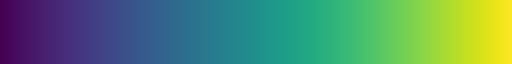

In [17]:
cmap = plt.cm.viridis
color=cmap(7/10)
cmap

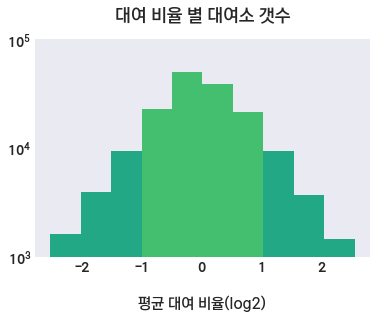

In [18]:

n, bins, patches = plt.hist(end[BM]['logRate'],bins=10,color=cmap(7/10))
for num,bar in enumerate(patches) :
    if num < 3 or num > 6 :
        bar.set_facecolor(cmap(6/10))
plt.yscale('log')
plt.xlabel('평균 대여 비율(log2)',fontdict={'fontsize':15},labelpad=20)
# plt.ylabel('값',fontdict={'fontsize':15},labelpad=20)
plt.title('대여 비율 별 대여소 갯수',fontdict={'fontsize':18},pad=20)


plt.xticks(fontsize=13,weight='bold')
plt.yticks([1000,10000,100000],fontsize=13,weight='bold')
plt.show()

In [19]:
quanJ = end.groupby(by='cat')['logRate'].mean()
quanJ2 = end.groupby(by='cat')['logRate'].size()
k = pd.DataFrame([np.power(2,quanJ),quanJ2]).T.reset_index()
k.columns = '고도차', '평균 반납 비율','대여소 개수'
# k['고도차'] = -k['고도차']
k['대여소 개수'] = k['대여소 개수'].astype(int)
k



,고도차,평균 반납 비율,대여소 개수
0,-40,0.649948,431
1,-30,0.665543,1437
2,-20,0.774725,4465
3,-10,0.881968,14896
4,0,0.992897,116852
5,10,1.111306,17394
6,20,1.259090,6004
7,30,1.387775,2012
8,40,1.632540,823
9,50,1.692734,358


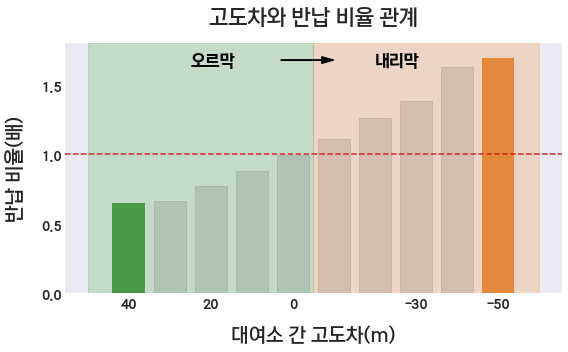

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
plt.axvspan(-1,4.5, alpha=0.2, color='tab:green')
plt.axvspan(4.5, 10, alpha=0.2, color='tab:orange')
pal = ['tab:green','tab:green','tab:green','tab:green','tab:green','tab:orange','tab:orange','tab:orange','tab:orange','tab:orange','tab:orange']
ax = sns.barplot(x='고도차', y='평균 반납 비율', data=k,palette=pal)
plt.axhline(y=1, color='tab:red',linestyle='--')
for num,bar in enumerate(ax.containers[0]) :
    if num == 0 or num == 9:
        bar.set_alpha(0.9)
    elif num  :
        bar.set_alpha(0.1)
        bar.set_color('black')


plt.xlabel('대여소 간 고도차(m)',fontdict={'fontsize':20},labelpad=15)
plt.ylabel('반납 비율(배)',fontdict={'fontsize':20},labelpad=15)
plt.title('고도차와 반납 비율 관계',fontdict={'fontsize':22},pad=20)


plt.xticks(ticks=[0,2,4,7,9] ,labels=[40,20,0,-30,-50],fontsize=13,weight='bold')
plt.yticks(ticks=[0,0.5,1,1.5], fontsize=13,weight='bold')
plt.ylim(0,1.8)
plt.text(1.5, 1.65, '오르막',fontdict={'fontsize' :17,'color': 'black','weight':'bold'})
plt.arrow(3.7, 1.68, 1, 0,head_width=0.05, head_length=0.3 ,fc='k', ec='k')
plt.text(6, 1.65, '내리막',fontdict={'fontsize' :17,'color': 'black','weight':'bold'})
plt.tight_layout()
plt.savefig('output.png',dpi=300)

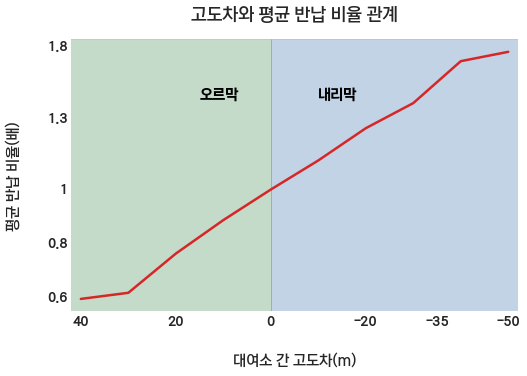

In [11]:
# quanJ1 = uphill.groupby(by='cat')['logRate'].mean()
# quanJ2 = downhill.groupby(by='cat')['logRate'].mean()
# sns.lineplot(data=quanJ1,color='tab:red',linewidth=2.5, ax=ax)
# sns.lineplot(data=quanJ2,color='tab:red',linewidth=2.5, ax=ax)
fig, ax = plt.subplots(figsize=(8,5))
quanJ = end.groupby(by='cat')['logRate'].mean()
sns.lineplot(data=quanJ,color='tab:red',linewidth=2.5)

plt.xlabel('대여소 간 고도차(m)',fontdict={'fontsize':15},labelpad=25)
plt.ylabel('평균 반납 비율(배)',fontdict={'fontsize':15},labelpad=25)
plt.title('고도차와 평균 반납 비율 관계',fontdict={'fontsize':18},pad=20)

# plt.yscale('log',base=2)
plt.xticks(ticks=[-40,-20,0,20,35,50] ,labels=[40,20,0,-20,-35,-50],fontsize=13,weight='bold')
plt.yticks(ticks=[-0.6,-0.3,0,0.4,0.8] ,labels=[0.6,0.80,1,1.3,1.8], fontsize=13,weight='bold')
plt.axvspan(-60, 0, alpha=0.2, color='tab:green')
plt.axvspan(0, 60, alpha=0.2, color='tab:blue')
plt.text(-15, 0.5, '오르막',fontdict={'fontsize' :15,'color': 'black','weight':'bold'})
plt.text( 10, 0.5, '내리막',fontdict={'fontsize' :15,'color': 'black','weight':'bold'})
plt.xlim(-42,52)
plt.show()

In [ ]:
j = pd.read_csv('./assets/saveForBikeRate.csv',encoding='cp949',index_col=0).sort_values(by='logRate',ascending=False)

### logRate 
# 1to2 2to1
# 1:1 = 0
# 2:1 = 1
# 4:1 = 2
# 1:2 = -1
# 1:4 = -2

j.head(3)

In [ ]:
#1to2 체크중
a = topk[['st_id1','st_id2']].values.tolist()
find = [1671,449]
# find = a[0]
kb = btstation[(btstation['value'].isin(find))].sort_values(by='value',ascending=False)
print(f'출발 대여소 : {kb.label.values[0]} ||  id : {kb.value.values[0]}')
print(f'도착 대여소 : {kb.label.values[1]} ||  id : {kb.value.values[1]}')
print('')
id1 = kb.value.values[0]
id2 = kb.value.values[1]
print(f'전체 대여기록 {len(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)])} 건')
print(seoul_bike[(seoul_bike["st_id1"] == id1) & (seoul_bike["st_id2"] == id2)]['date'].dt.hour.value_counts().head(5))

# drawMap(find)

In [ ]:
test1 = np.abs(k['logRate'])
# test2= pd.cut(test1,bins=[0,1,2,3,4,8],labels=['1~2배','2~4배','4~8배','8~16배','16배~'])
test2= pd.cut(test1,10)
# test2 = test2.fillna(0)

In [ ]:
test2= pd.cut(test1,bins=[-6,-2,-1,1,2,6])
test2bar = test2.values.describe()
test2bar['counts'].plot.bar()

test3 = pd.cut(test1,bins=[-1,-0.5,0,0.5,1]).dropna()
test3bar = test3.values.describe()
test3bar['counts'].plot.bar()

In [ ]:
plt.figure(figsize=(6,5))
test2bar=test2.value_counts().sort_values(ascending=False)
plt.barh(y=test2bar.index,width=test2bar,)
plt.title(label='대여소 이동 비율 차이',fontdict={'size': 20},y=1.05)
plt.xlabel(xlabel='A->B/B->A',fontdict={'size':14})
plt.ylabel(ylabel='대여소(개)',fontdict={'size':14})
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')

### 고도 그래프 그리기

In [36]:
seoulGeo = pd.read_csv('./assets/seoulGeoposition.csv',index_col=0)
seoulGeo.head(2)

,longtitude,latitude,elevation
0,126.848503,37.572940,2.71
1,126.848505,37.572129,4.00


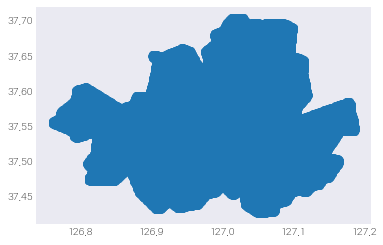

In [37]:
# 데이터 확인
plt.scatter(seoulGeo['longtitude'],seoulGeo['latitude'])

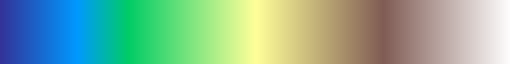

In [38]:
from matplotlib.colors import LinearSegmentedColormap

def chop_cmap_frac(cmap: LinearSegmentedColormap, frac: float) -> LinearSegmentedColormap:
    """Chops off the beginning `frac` fraction of a colormap."""
    cmap_as_array = cmap(np.arange(256))
    cmap_as_array = cmap_as_array[int(frac * len(cmap_as_array)):]
    return LinearSegmentedColormap.from_list(cmap.name + f"_frac{frac}", cmap_as_array)

cmap = plt.cm.terrain
# cmap = chop_cmap_frac(cmap, 0.1)
cmap


180


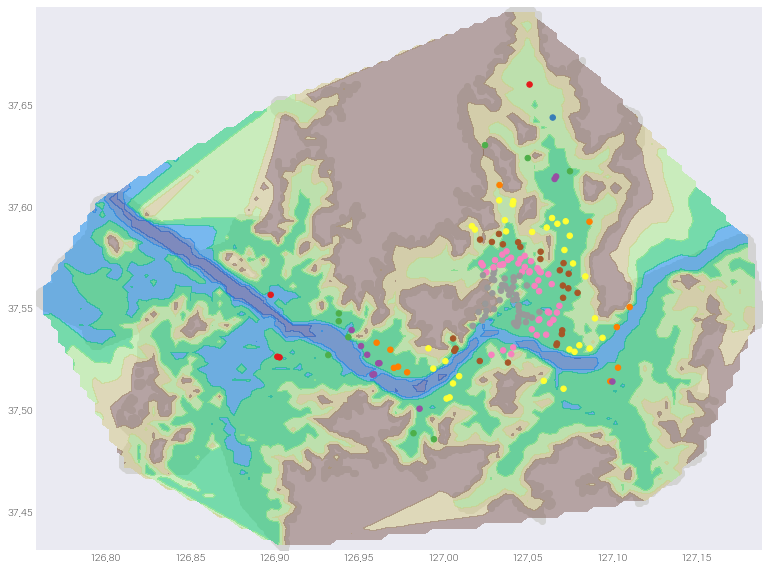

In [39]:
import geojsoncontour
from scipy.interpolate import griddata

## 70미터 이하만 추출(대부분 대여소가 70m 미만에 있음)
newseoulGeo = seoulGeo[(seoulGeo['elevation'] <= 50 )& (seoulGeo['elevation'] >= 0 ) ]
x = newseoulGeo.iloc[:,0].values
y = newseoulGeo.iloc[:,1].values
z = newseoulGeo.iloc[:,2].values

# Contour 만드는데 도움주는 function
def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

X,Y,Z = plot_contour(x,y,z,resolution = 100,contour_method='linear')

# matplotlib에서 그리는 용도
level = [0,3,5]
level.extend(list(range(10,70,10)))
fig, ax = plt.subplots(figsize=(13,10))
plt.scatter(x,y,color='lightgray')
plt.contourf(X,Y,Z,levels=level, alpha =0.5 ,cmap=cmap) # 색만 칠하기

# map(lambda x : folium.CircleMarker(x, radius=2,weight=5).add_to(geomap),)
id = 3511
sortedStation =rawStation(id)
coor = sortedStation[['latitude','longtitude']].values.tolist()
distLabel = sortedStation['distLabel'].tolist()
print(len(sortedStation))

plt.scatter(sortedStation['longtitude'],sortedStation['latitude'],c=sortedStation['distLabel'],cmap=plt.cm.Set1_r, s=30)
# plt.contour(X,Y,Z,levels=level,linewidths=0.2,colors='black') # 등고선만 그리기

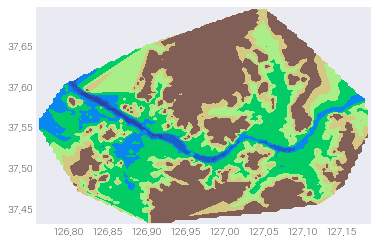

In [40]:

# GeoJson 추출
figure = plt.figure()
ax = figure.add_subplot(111)
contourf = ax.contourf(X, Y, Z, cmap=cmap,levels=level)

geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=3,
    stroke_width=1,
    fill_opacity=1
    )

### 지도에 고도 데이터 입히기

In [41]:
station.query('district == "중구"').sort_values(by='num',ascending=False)[10:30]

,st_id,st_name,district,latitude,longtitude,num,elevation
316,473,을지로4가역 9번출구,중구,37.566051,126.997986,23335.0,25.02
587,826,서울역 서부교차로2,중구,37.555367,126.968643,23051.0,27.08
2445,375,다산 어린이공원,중구,37.563717,127.018425,22732.0,25.09
233,380,CJ제일제당 앞,중구,37.563866,127.002747,22594.0,26.54
183,310,청계광장 옆,중구,37.568878,126.977470,22542.0,29.36
2392,4765,동대문디자인플라자,중구,37.568314,127.009461,21599.0,19.84
174,300,정동사거리,중구,37.568050,126.969231,21506.0,42.59
2409,4796,부산은행,중구,37.566471,126.979256,20519.0,28.38
239,387,훈련원공원주차장 앞,중구,37.566994,127.003464,19735.0,22.62
187,320,을지로입구역 4번출구 앞,중구,37.566223,126.983589,19463.0,27.11


In [42]:
# map(lambda x : folium.CircleMarker(x, radius=2,weight=5).add_to(geomap),)
id = 207
sortedStation =rawStation(id)
coor = sortedStation[['latitude','longtitude']].values.tolist()
distLabel = sortedStation['distLabel'].tolist()
# print(len(sortedStation))
# sortedStation['distLabel'].value_counts()

### 자전거 대여 비율로 고도 높은 대여소를 얼마나 잘 걸러내는지 확인한 실험 

In [47]:
import folium

colors = [
    'beige',
    'purple',
    'orange',
    'green',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
        'lightblue',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]
mainStationCoor = station[station['st_id']==id][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,
)
folium.TileLayer('CartoDB positron').add_to(geomap)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'color': x['properties']['fill'],
        'opacity':   1,
        'fill_opacity' : 1,
    }).add_to(geomap)
for i, c in enumerate(distLabel) : 
    folium.CircleMarker(coor[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    # folium.CircleMarker(coor[i],radius=2,weight=6,color=colors[c],opacity=0.9).add_to(geomap)
    folium.CircleMarker(coor[i],radius=2,weight=6,color='green',opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)


geomap


변화 측정하기

In [ ]:
# # 대여기록 비율 1/2 차이나는 경우 station으로 미포함
# def calculateBikeRate(id1:int, id2:int, rawData)-> pd.Series :
#     k = rawData[(rawData['st_id1'] == id1) & (rawData['st_id2'] == id2)] # 주 목적
#     kk = rawData[(rawData['st_id1'] == id2) & (rawData['st_id2'] == id1)] # 비교 목적
#     if len(k) and len(kk) :
#         rere = np.log2(len(k)/len(kk))
#         if rere > -1 :
#             return [id2,len(k),len(kk)]   

# filteredidx= sortedStation['st_id'].tolist()
# result = [calculateBikeRate(id,id2,raw_data(id)) for id2 in filteredidx]
# b=[a for a in result if a ]
# k = pd.DataFrame(b)
# k['logRate'] = np.log2(k[1]/k[2])
# k.sort_values(by='logRate')

In [44]:
# map(lambda x : folium.CircleMarker(x, radius=2,weight=5).add_to(geomap),)
# newSortedStation =filterRawStations(id)
newSortedStation =extractStations(id)
newCoor = newSortedStation[['latitude','longtitude']].values.tolist()
newSortedStation['distLabel'] = newSortedStation['haversineDist'].astype(int)
newDistLabel = newSortedStation['distLabel'].tolist()
print(len(newSortedStation))

40


In [ ]:
# newSortedStation.sort_values(by='elevation')

In [48]:
mainStationCoor = station[station['st_id']==id][['latitude','longtitude']].values.tolist()[0]
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)

folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.8,
    }).add_to(geomap)
    
for i, c in enumerate(newDistLabel) : 
    folium.CircleMarker(newCoor[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    # folium.CircleMarker(newCoor[i],radius=2,weight=6,color=colors[c],opacity=0.9).add_to(geomap)
    folium.CircleMarker(newCoor[i],radius=2,weight=6,color='green',opacity=0.9).add_to(geomap)


folium.CircleMarker(mainStationCoor,radius=4,weight=8,color='red').add_to(geomap)
folium.CircleMarker(mainStationCoor,radius=2,weight=6,color='black').add_to(geomap)


geomap


### 고도와 좌표 데이터로 클러스터링 해보기
* 클러스터링 형성 시 고도에 영향을 매우 많이 받음

In [ ]:
k = station[['latitude','longtitude']]
kmeans = KMeans(n_clusters=10, random_state=42)
a = kmeans.fit(k)
k['label'] = a.labels_

k['elevation'] = station['elevation']
newk = k[k['label'] == 4]
kmeans = KMeans(n_clusters=5, random_state=42)
a = kmeans.fit(newk)
newk['label'] = a.labels_

coork = newk[['latitude','longtitude']].values.tolist()


### DBSCAN 테스트

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coork))
newk['label'] = db.labels_
newk['label']=newk['label'].replace(-1,20)

In [ ]:
geomap = folium.Map(mainStationCoor, zoom_start=12,)
folium.TileLayer('https://api.mapbox.com/styles/v1/yangoos/cl4vjjz0c001n14sk1ytnj9ix/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA',attr='서울투어-copy').add_to(geomap)
for i, c in enumerate(newk['label']) : 
    folium.CircleMarker(coork[i],radius=3,weight=6,color='black',opacity=0.7).add_to(geomap)
    folium.CircleMarker(coork[i],radius=2,weight=6,color=colors[c],opacity=0.9).add_to(geomap)

geomap

In [ ]:
창고

In [ ]:
창고

In [ ]:
창고

### 창고

In [ ]:
def haversineOneStation(id:int,station) -> pd.DataFrame :
    '''
    선택한 대여소를 기준으로 이용기록이 있는 대여소의 직선 거리와 대여 건수를 계산한다. 

    '''
    # st_id2 선정
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()
    # 대여기록 10건 이상인 대여소만 수집
    data = stationInteraction[stationInteraction>=int(np.sum(stationInteraction)/1000)].sort_values(ascending=False)

    # dep & arr station info
    dep = station[station['st_id'].isin([id])]
    arr = station[station['st_id'].isin(data.index.tolist())]

    # haversine으로 거리 구하기
    depLong = dep['longtitude'].values
    depLat = dep['latitude'].values
    arrLong=arr['longtitude']
    arrLat=arr['latitude']
    dist = haversine_np(depLong,depLat,arrLong,arrLat)
    dist = pd.DataFrame(dist/1000,columns=['dist'])
    dist['st_id'] = arr['st_id']
    # 결과종합
    result = pd.DataFrame(data,columns=['count']).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2','count']]
    result = pd.merge(left=result, right=dist, left_on='st_id2',right_on='st_id')

    return result.drop(columns='st_id')
haversineOneStation(207,station)


### 자전거 대여 비율로 고도 높은 대여소를 얼마나 잘 걸러내는지 확인한 실험 

In [ ]:
# from tqdm.notebook import tqdm
# # 조건 1,2 정제해서 index로 반환
# def filterConditions(id1:int,rawData) -> np.array :
#     # rawData = raw_data(id1)
#     id2List = filterIn1000M(id1)['st_id'].to_numpy()

#     # 조건 1 : 대여기록 0.001 이상
#     id1Value = rawData['st_id2'].value_counts()[1:]
#     id1List= id1Value[id1Value>int(len(rawData)*0.001)].index.to_numpy() 

#     #조건 2 : 비율 2배 이상, 고도 차이 20m 이상 제거
#     filteredidx = id1List[~(np.in1d(id1List,id2List))] 
#     result = [calculateBikeRate(id1,id2,rawData) for id2 in filteredidx]

#     returnValue : np.array = pd.concat(result)['st_id2'].value_counts().index.to_numpy()
#     return filteredidx, returnValue

# result=[]
# for id in tqdm(station['st_id'].unique()) :
#     id1, val = filterConditions(id,raw_data(id))
#     result.append([id,len(id1)-len(val)])

